# Exemplo de implementação de ConvNet utilizando o Keras

In [1]:
# alguns imports necessários
from matplotlib import pyplot as plt  # import para fazer a plotagem de figuras
import numpy as np  # principal biblioteca para computação numérica

# necessario para plotar as imagens dentro do Ipython notebook
%matplotlib inline 

Fala pessoal! Eu queria começar de alguma maneira esse nosso projeto, então decidi fazer um ipython comentado de uma aplicação clássica de ConvNets utilizando a base de dados MINST.

Não sei se todos sabem do que se trata essa base de dados, então vou fazer uma breve explicação. A base MNIST contém umas 70 mil imagens de *digitos escritos em letra cursiva* e normalmente a aplicação da ConvNet é para identificar os números.

**Como importar a base de dados? **

In [2]:
#from keras.datasets import mnist
from keras.datasets import cifar100
import keras

Using TensorFlow backend.


In [3]:
from matplotlib import pyplot as plt

** Como são essas imagens? **

In [5]:
#num_imagens = 3
#dataset = mnist.load_data()
#for _ in range(num_imagens):
#    plt.figure()
#    plt.imshow(dataset[0][0][np.random.randint(20, 1000)], cmap='Greys_r')

Essa base de dados é tão popular que o próprio Keras já faz o import dos dados de treino e teste de maneira automatica. A notação que vou utilizar é a clássica que encontra nos tutoriais pela internet. X_treino, y_treino para dados de *input* e *target* respectivamente. Os inputs utilizam uma letra maiúscula para diferenciar que estamos falando de uma matriz enquanto que o target seria apenas um vetor.

In [6]:
(X_treino, y_treino), (X_teste, y_teste) = cifar100.load_data(label_mode='fine')

In [7]:
print("Dimensões dos dados de treino e teste")
print("Dimensoes do treino:  inputs: {} targets: {} num_exemplos: {}".format(X_treino.shape, y_treino.shape, len(X_treino)))
print("Dimensoes do teste:  inputs: {} targets: {} num_exemplos: {}".format(X_teste.shape, y_teste.shape, len(X_teste)))
print("Tipo de estrutura de dados: ", type(X_treino))

Dimensões dos dados de treino e teste
Dimensoes do treino:  inputs: (50000, 32, 32, 3) targets: (50000, 1) num_exemplos: 50000
Dimensoes do teste:  inputs: (10000, 32, 32, 3) targets: (10000, 1) num_exemplos: 10000
('Tipo de estrutura de dados: ', <type 'numpy.ndarray'>)


Podemos começar a manipulação dos dados para conseguir utilizar dentro de um modelo de machine learning.

1. Precisamos colocar os dados em um formato que o Keras entenda. Teremos que passar matrizes para o modelo de rede neural, porém até lá temos que utilizar algumas outras bibliotecas para categorizar os dados. Então o primeiro passo é apenas passar os dados acima com formato (60000, 28, 28) para (60000, 28, 28, 1) e definir o tipo dos valores como float.

OBS: Tomar um pouco de cuidado aqui. Se você estiver utilizando o TensorFlow como backend, o conjunto de treino deve ter o formado que colocamos acima. (batch_size, altura, largura, 1). Porém caso utilizem o Theano como backend, então o formato muda um pouco: (batch_size, 1, altura, largura). Se não me engano é apenas uma definição de como eles ordenam as imagens.

In [8]:
qtd_linhas = 32
qtd_colunas = 32

X_treino = X_treino.reshape(X_treino.shape[0], qtd_linhas, qtd_colunas, 3).astype('float')
X_teste = X_teste.reshape(X_teste.shape[0], qtd_linhas, qtd_colunas, 3).astype('float')

In [9]:
# nessa etapa precisamos normalizar as *intensidades* de cada imagem
# elas variam de [0, 255] precisamos colocar de [0, 1]

X_treino /= 255
X_teste /= 255

In [10]:
X_treino.shape

(50000, 32, 32, 3)

A próxima etapa é bem importante. Abaixo vou colocar um preview dos nossos dados de target. Já adiantando, os dados de target são os significados das imagens, ou seja, se uma imagem tem um 5 escrita com uma gráfia bem ruim, o target dessa amostra é o próprio valor 5. 

Porém, utilizar o target dessa maneira, pode não ser uma boa ideia. Fiz alguns testes no passado que apresentou algumas melhoras ao utilizar um target categorico no lugar da variável real.

In [11]:
y_treino

array([[19],
       [29],
       [ 0],
       ..., 
       [ 3],
       [ 7],
       [73]])

O que seriam variáveis categoricas? Digamos que temos apenas 3 classes de números em um determinado problema. "REAL, INTEIRO, IMAGINÁRIO".

A lista de targets poderia ser: [1.2, 2, 3, 4.2, 4i]
No lugar de passar a lista acima, poderiamos categorizar em uma matriz onde cada linha mostra uma representação binarizada da variável target.

|target ||REAL|INTEIRO|IMAGINARIO|
|:----: |:-:|:--:|:-----:|:----:|
|1.2||1|0|0|
|2||0|1|0|
|3||0|1|0|
|4.2||1|0|0|
|4i||0|0|1|

Assim, passamos essa matriz binarizada para a rede. Várias bibliotecas tem implementada essa funcionalidade. O pandas usa o método .get_dummies(), no Keras podemos usar um método chamado **to_categorical**

In [12]:
from keras.utils.np_utils import to_categorical

In [13]:
numero_classes = 100  # temos de 0 a 9 no dataset
y_treino = to_categorical(y_treino, numero_classes)
y_teste = to_categorical(y_teste, numero_classes)

Finalmente, podemos criar o modelo de rede neural para o problema de reconhecimento de digitos. No Keras tem uma gama bem grande de modelos prontos, basta instanciar e montar as camadas.

O modelo de rede neural convolucional apresenta básicamente os seguintes componentes:

1. Uma camada convolucional
2. Uma camada de Pooling
3. Uma camada completamente conectada
4. Uma camada completamente conectada com Softmax como função de ativação

Acho que nessa estrutura podemos avançar mais sobre o entendimento delas. Deixar mais claro o que cada uma está fazendo, com exemplos visuais se possível. E um pouco de intuição sobre o fenômeno.

In [14]:
from keras.models import Sequential

In [15]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

Também é necessário informar alguns parâmetros como o número de filtros convolucionais, tamanho da janela dos filtros, tamanho da janela de pooling. Tudo bem empírico.

In [16]:
num_filtros = 32
num_conv = 2
num_pool = 2
numero_classes = 100

In [17]:
from keras.layers import Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.layers.core import Dropout

has_drop = True
dropout_rate=0.3

In [18]:

has_drop = True

   
modelo = Sequential() # na documentação do Keras 
#tem um pouco sobre o funcionamento desse modelo
# basicamente, voce pode ir 'empilhando' camadas


def keras_add(m,op):
    m.add(op)
    l = m.layers[-1]
    print l.name, l.get_output_shape_at(-1)


keras_add(modelo,Convolution2D(num_filtros, num_conv, num_conv, 
                         border_mode='valid',
                         input_shape=(32, 32, 3)))
keras_add(modelo,Activation('relu'))
#keras_add(modelo,Convolution2D(num_filtros, num_conv, num_conv))
#keras_add(modelo,Convolution2D(num_filtros, 12, 2))
#1
keras_add(modelo,Convolution2D(32, 3, 3))
keras_add(modelo,Activation('relu'))
keras_add(modelo,MaxPooling2D(pool_size=(2, 2)))
keras_add(modelo,Dropout(0.25))

#2
keras_add(modelo,Convolution2D(64, 3, 3))
keras_add(modelo,Activation('relu'))
keras_add(modelo,Convolution2D(64, 3, 3))
keras_add(modelo,Activation('relu'))
keras_add(modelo,MaxPooling2D(pool_size=(2, 2)))
keras_add(modelo,Dropout(0.25))

#
keras_add(modelo,Flatten()) # 'comprime' o dado para ser possivel utilizar em uma camada 1
keras_add(modelo,Dense(512)) # 200 eh o numero de neuronios dessa camada
keras_add(modelo,Activation('relu'))
keras_add(modelo,Dropout(0.25))
keras_add(modelo,Dense(100)) # 200 eh o numero de neuronios dessa camada
keras_add(modelo,Dense(numero_classes))

keras_add(modelo,Activation('softmax')) # o resultado aqui vai ser a probabilidade de cada classe


convolution2d_1 (None, 31, 31, 32)
activation_1 (None, 31, 31, 32)
convolution2d_2 (None, 29, 29, 32)
activation_2 (None, 29, 29, 32)
maxpooling2d_1 (None, 14, 14, 32)
dropout_1 (None, 14, 14, 32)
convolution2d_3 (None, 12, 12, 64)
activation_3 (None, 12, 12, 64)
convolution2d_4 (None, 10, 10, 64)
activation_4 (None, 10, 10, 64)
maxpooling2d_2 (None, 5, 5, 64)
dropout_2 (None, 5, 5, 64)
flatten_1 (None, 1600)
dense_1 (None, 512)
activation_5 (None, 512)
dropout_3 (None, 512)
dense_2 (None, 100)
dense_3 (None, 100)
activation_6 (None, 100)


A próxima etapa utilizando o Keras é compilar o modelo que foi definido acima

In [19]:
#modelo.compile(loss='categorical_crossentropy',
#              optimizer='adadelta',
#              metrics=['accuracy']) 

modelo.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) 

history = LossHistory()
# bastante coisas aqui para estudar também. 

Agora podemos treinar o nosso modelo com os dados

In [20]:
num_epocas = 10
batch_size = 128


modelo.fit(X_treino, y_treino, batch_size=batch_size,
          nb_epoch=num_epocas, validation_data=(X_teste, y_teste), callbacks=[history])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 212s - loss: 4.2178 - acc: 0.0515 - val_loss: 3.9076 - val_acc: 0.0961
Epoch 2/10
50000/50000 [==============================] - 218s - loss: 3.8309 - acc: 0.1066 - val_loss: 3.6665 - val_acc: 0.1368
Epoch 3/10
50000/50000 [==============================] - 222s - loss: 3.6722 - acc: 0.1347 - val_loss: 3.5244 - val_acc: 0.1633
Epoch 4/10
50000/50000 [==============================] - 222s - loss: 3.5429 - acc: 0.1569 - val_loss: 3.3794 - val_acc: 0.1960
Epoch 5/10
50000/50000 [==============================] - 224s - loss: 3.3877 - acc: 0.1837 - val_loss: 3.2030 - val_acc: 0.2262
Epoch 6/10
50000/50000 [==============================] - 222s - loss: 3.2363 - acc: 0.2146 - val_loss: 3.0987 - val_acc: 0.2431
Epoch 7/10
50000/50000 [==============================] - 224s - loss: 3.1222 - acc: 0.2330 - val_loss: 2.9485 - val_acc: 0.2756
Epoch 8/10
50000/50000 [=======================

Agora basta verificar as métricas do modelo treinado. É um pouco demorado fazer o treinamento desse modelo em um notebook normal. Vou tentar rodar no meu desktop no trabalho na segunda-feira e ver se é um pouco mais rápido. Por isso coloquei apenas 1 epoca de treinamento.

In [21]:
loss, accuracy = modelo.evaluate(X_teste, y_teste)
print loss,accuracy

10000/10000 [==============================] - 14s    
2.77032169914 0.3118


Após essa etapa ainda é possivel fazer previsões e verificar outras métricas com os métodos .predict_proba, .predict_classes. A partir daqui podemos continuar esse mesmo exemplo e ver como se sai.

Espero que isso tudo tenha sido útil para mais alguém além de mim. o/

Flws!

loss: 2.770322 	 accuracy: 0.311800


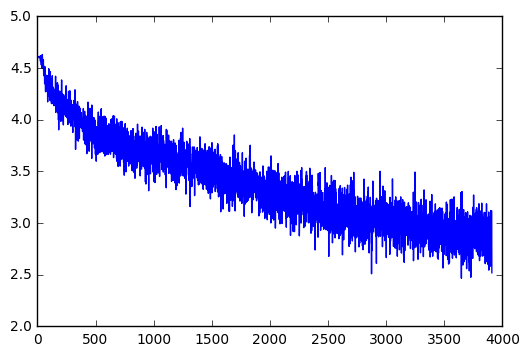

In [22]:
plt.plot(history.losses)
print "loss: %f \t accuracy: %f" % (loss, accuracy)

In [23]:
modelo.save('model_cifar.h5')
modelo.save_weights('weights_cifar.h5')